In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import gzip
from sklearn.model_selection import train_test_split

# === 1. Load and Parse RIPE BGP update files ===
def parse_bgp_updates(folder_path):
    all_lines = []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith(".txt"):
            with open(os.path.join(folder_path, file), 'r', encoding='utf-8', errors='ignore') as f:
                lines = f.readlines()
                all_lines.extend(lines)
    return all_lines

# === 2. Feature Extraction ===
def extract_bgp_features(lines):
    feature_vectors = []
    labels = []
    for line in lines:
        if line.startswith("BGP4MP"):
            parts = line.split('|')
            if len(parts) > 6 and parts[5].strip():
                try:
                    feature = [len(parts[5].strip())]  # basic feature: message length
                    feature_vectors.append(feature)
                    ts = int(parts[1])  # timestamp
                    if 1581897600 <= ts <= 1582156799:
                        labels.append(1)  # attack
                    else:
                        labels.append(0)  # normal
                except Exception:
                    continue
    if not feature_vectors:
        raise ValueError("No valid features extracted. Check the .txt file contents.")
    return pd.DataFrame(feature_vectors), pd.Series(labels)

# === 3. Preprocessing ===
def preprocess_features(X, y):
    if X.shape[0] < 5:
        print("[Warning] Too few examples available. Skipping PCA.")
        X_scaled = MinMaxScaler().fit_transform(X)
        return pd.DataFrame(X_scaled), y.reset_index(drop=True)
    else:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        n_components = min(5, X_scaled.shape[0], X_scaled.shape[1])
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        return pd.DataFrame(X_pca), y.reset_index(drop=True)

# === 4. Sequence Creation ===
def create_sequences(data, targets, window_size=10):
    X = np.array([data[i:i+window_size] for i in range(len(data) - window_size)])
    y = np.array([targets[i+window_size-1] for i in range(len(targets) - window_size)])
    return X, y

# === 5. Jerk System ===
def jerk_system(t, state, u):
    x, y, z = state
    dx = y
    dy = z
    dz = -z - x - 1e-9 * (np.exp(y / 0.026) - 1) + u
    return [dx, dy, dz]

def simulate_jerk(signal, dt=0.1):
    state = [0.0, 0.0, 0.0]
    states = []
    for u in signal:
        sol = solve_ivp(lambda t, y: jerk_system(t, y, u), [0, dt], state, method='RK45')
        state = sol.y[:, -1]
        states.append(state)
    return np.array(states)

# === 6. Evaluation Function ===
def evaluate_model(name, y_true, y_pred):
    print(f"\n[{name}]")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1-score (DoS):", f1_score(y_true, y_pred, pos_label=1))
    print("F1-score (Normal):", f1_score(y_true, y_pred, pos_label=0))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, labels=[0, 1], target_names=['normal', 'dos'], zero_division=0))

# === Optional: Inspect .gz files ===
def inspect_gz_files(folder_path, max_lines=5):
    print("Inspecting .gz file contents...")
    for file in sorted(os.listdir(folder_path)):
        if file.endswith(".gz"):
            path = os.path.join(folder_path, file)
            try:
                with gzip.open(path, 'rt', encoding='utf-8', errors='ignore') as f:
                    print(f"File: {file}")
                    for i, line in enumerate(f):
                        if i >= max_lines:
                            break
                        print(line.strip())
            except Exception as e:
                print(f"Error reading {file}: {e}")

# === Pipeline Execution ===
# Read and process data
lines = parse_bgp_updates("/Users/thalitanazare/Documents/25ICECS/dataripe/ddos2020_rrc14")
X_raw, y_raw = extract_bgp_features(lines)
X_proc, y_proc = preprocess_features(X_raw, y_raw)
X_seq, y_seq = create_sequences(X_proc, y_proc)

# Train-test split (80/20)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

# === Jerk-based Reservoir Computing ===
X_train_jerk = np.array([simulate_jerk(np.mean(seq, axis=1)).flatten() for seq in X_train_seq])
X_test_jerk = np.array([simulate_jerk(np.mean(seq, axis=1)).flatten() for seq in X_test_seq])

clf_jerk = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf_jerk.fit(X_train_jerk, y_train_seq)
y_pred_jerk = clf_jerk.predict(X_test_jerk)
evaluate_model("RC with Jerk", y_test_seq, y_pred_jerk)



[ESN5]
Accuracy: 0.5700639463320242
F1-score (DoS): 0.6634851394624016
F1-score (Normal): 0.4048389960821058
Confusion Matrix:
 [[ 53577  52216]
 [105313 155295]]
              precision    recall  f1-score   support

      normal       0.34      0.51      0.40    105793
         dos       0.75      0.60      0.66    260608

    accuracy                           0.57    366401
   macro avg       0.54      0.55      0.53    366401
weighted avg       0.63      0.57      0.59    366401


[RC with Jerk]
Accuracy: 0.6381232583972205
F1-score (DoS): 0.7424147644487615
F1-score (Normal): 0.3919248619595326
Confusion Matrix:
 [[ 42730  63063]
 [ 69529 191079]]
              precision    recall  f1-score   support

      normal       0.38      0.40      0.39    105793
         dos       0.75      0.73      0.74    260608

    accuracy                           0.64    366401
   macro avg       0.57      0.57      0.57    366401
weighted avg       0.64      0.64      0.64    366401



ValueError: Found input variables with inconsistent numbers of samples: [1832005, 366401]

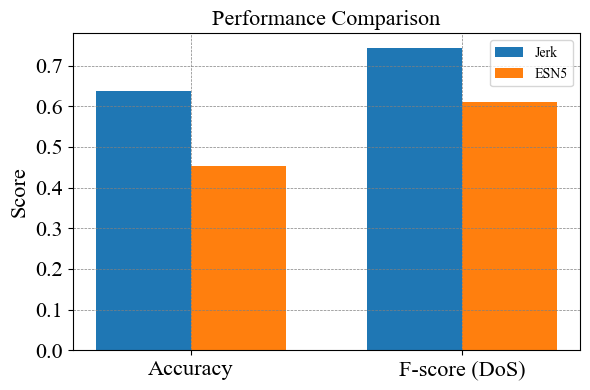

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Accuracy', 'F-score (DoS)']
jerk_values = [0.638, 0.742]
esn5_values = [0.453, 0.610]

# Config
fontsize = 16
fontname = 'Times New Roman'
bar_width = 0.35
x = np.arange(len(metrics))

# Plot
plt.figure(figsize=(6, 4))
plt.bar(x - bar_width/2, jerk_values, width=bar_width, label='Jerk')
plt.bar(x + bar_width/2, esn5_values, width=bar_width, label='ESN5')

plt.xticks(x, metrics, fontsize=fontsize, fontname=fontname)
plt.yticks(fontsize=fontsize, fontname=fontname)
plt.title('Performance Comparison', fontsize=fontsize, fontname=fontname)
plt.ylabel('Score', fontsize=fontsize, fontname=fontname)
plt.grid(True, color='grey', linestyle='--', linewidth=0.5)
plt.legend(fontsize=fontsize, prop={'family': fontname})
plt.tight_layout()
plt.savefig('fig_compare_article.svg', format='svg')
plt.show()
